# Team 3 - Merchant Category Recommendation
## Feature Extraction

### Team 3
- Vinicio De Sola
- Kevin Hanna
- Pri Nonis
- Bradley Nott

The results from Feature Engineering should get cleaned up here before modeling. 

In [1]:
import numpy               as np
import matplotlib.pyplot   as plt
import pandas              as pd
import seaborn             as sb

from datetime              import timedelta, datetime

from sklearn               import metrics
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn.mixture       import GaussianMixture
from sklearn.linear_model  import LinearRegression
from sklearn.model_selection import KFold

from matplotlib.colors     import LogNorm

from IPython.display       import HTML, Markdown

from sklearn.metrics       import mean_squared_error

import lightgbm as lgb

%matplotlib inline

np.random.seed(0)

import os
print(os.listdir("./input"))

['historical_transactions.csv', '.ipynb_checkpoints', 'new_merchant_transactions.csv', 'engineered_test.pkl', 'merchants.csv', 'sample_submission.csv', 'test.csv', 'Data_Dictionary.xlsx', 'features_importance_kfold.pkl', 'engineered_train.pkl', '.gitignore', 'train.csv']


## Read in all the data files

In [2]:
train        = pd.read_pickle('input/engineered_train.pkl')
test         = pd.read_pickle('input/engineered_test.pkl')

target = train['target']
del      train['target']

## A view of our new training data dataframe

In [3]:
display(train.head())
display(test.head())

,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,...,auth_month_lag_max,auth_month_lag_std,auth_authorized_flag_sum,auth_month_diff_mean,auth_month_diff_min,auth_month_diff_max,auth_month_diff_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,1,246,0,0,0,0,1,0,1,0,...,0,2.429155,247,-0.048583,-1,0,0.215431,20977987.0,1.498573e+09,1.519551e+09
C_ID_3d0044924f,0,397,0,0,0,1,0,1,0,0,...,0,3.836969,339,0.961652,0,1,0.192319,33717687.0,1.483720e+09,1.517438e+09
C_ID_d639edf6cd,0,550,0,1,0,0,0,0,1,0,...,0,3.893083,41,-0.024390,-1,0,0.156174,35635623.0,1.484123e+09,1.519759e+09
C_ID_186d6a6901,0,154,0,0,0,1,0,0,0,1,...,0,1.802065,77,-0.038961,-1,0,0.194771,13375339.0,1.506443e+09,1.519818e+09
C_ID_cdbd2c0db2,0,93,1,0,0,0,0,0,0,1,...,0,1.026680,128,-0.023438,-1,0,0.151883,9405641.0,1.510445e+09,1.519850e+09


,first_active_month,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,...,auth_month_lag_max,auth_month_lag_std,auth_authorized_flag_sum,auth_month_diff_mean,auth_month_diff_min,auth_month_diff_max,auth_month_diff_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,2017-04-01,1,307,0,0,1,0,0,0,0,...,0,2.574370,44,1.977273,1,2,0.150756,23179380.0,1.491330e+09,1.514510e+09
C_ID_130fd0cbdd,2017-01-01,0,397,0,1,0,0,0,0,0,...,0,2.172971,77,-0.012987,-1,0,0.113961,34667913.0,1.484321e+09,1.518989e+09
C_ID_b709037bc5,2017-08-01,1,185,0,0,0,0,1,1,0,...,0,1.641476,9,0.000000,0,0,0.000000,13924886.0,1.503673e+09,1.517598e+09
C_ID_d27d835a9f,2017-12-01,0,63,0,1,0,0,0,1,0,...,0,0.951113,26,0.000000,0,0,0.000000,6734846.0,1.512392e+09,1.519127e+09
C_ID_2b5e3df5c2,2015-12-01,1,794,0,0,0,0,1,1,0,...,0,4.222494,87,0.000000,0,0,0.000000,36174127.0,1.483554e+09,1.519728e+09


In [4]:
def compress(df) :
    pre = df.memory_usage().sum() / 1024**2 / 8
    cmp = {'f' : {np.finfo(np.float16).max : np.float16,
                  np.finfo(np.float32).max : np.float32,
                  np.finfo(np.float64).max : np.float64},
           'i' : {np.iinfo(np.int8   ).max : np.int8,
                  np.iinfo(np.int16  ).max : np.int16,
                  np.iinfo(np.int32  ).max : np.int32,
                  np.iinfo(np.int64  ).max : np.int64}}

    for c in df.columns :
        if  cmp.get(df[c].dtype.kind) :
            df[c] = df[c].astype(cmp[df[c].dtype.kind].get(min((n for n in cmp[df[c].dtype.kind].keys() if n > max(df[c].max(), abs(df[c].min()))))))

    end = df.memory_usage().sum() / 1024**2 / 8

    print(f'Memory Use Decreased to {end:5.2f} MB [{100 * (pre - end) / pre:.1f}% Reduction]')

    return df

# Feature Extraction
Analyze and select features for modeling
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [5]:
# Store results
feature_score_df = pd.DataFrame()

early_stoping_rounds = 100

param = {
    'num_leaves':100, 
    'num_trees':100, 
    'objective':'regression',
    'metric': 'rmse',
    "verbosity": -1}

# train = compress(train)
# test = compress(test)


folds = KFold(n_splits=10, shuffle=True, random_state=15)
for fold_, (train_index, validation_idex) in enumerate(folds.split(train.values, target.values)):

    train_data_fold = lgb.Dataset(train.iloc[train_index], label=target.iloc[train_index])
    validation_data_fold = lgb.Dataset(train.iloc[validation_idex], label=target.iloc[validation_idex])
    
    foo = {}
    num_round = 10000
    clf = lgb.train(param,
                    train_data_fold,
                    num_round,
                    valid_sets = [train_data_fold, validation_data_fold],
                    verbose_eval=100,
                    early_stopping_rounds = early_stoping_rounds)

    y_pred  = clf.predict(train.iloc[validation_idex])
    
    mse = mean_squared_error(target.iloc[validation_idex], y_pred)
    gain = (14.269 - mse) / 14.269 * 100
    print(f"Lasso : Mean Squared Error is {mse:6.3f} [{gain:+6.3f}]")
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_score_df = pd.concat([feature_score_df, fold_importance_df], axis=0)
    
    # here are the best coeffecients for the round
    print(clf.predict(train.iloc[validation_idex], num_iteration=clf.best_iteration))


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.9917	valid_1's rmse: 3.73732
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.9917	valid_1's rmse: 3.73732
Lasso : Mean Squared Error is 13.968 [+2.112]
[-0.00650412 -0.21739158 -0.4965449  ...  0.27138518 -0.53450096
 -0.17919177]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.00085	valid_1's rmse: 3.69995
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.00085	valid_1's rmse: 3.69995
Lasso : Mean Squared Error is 13.690 [+4.060]
[-0.16672262  0.12365986 -0.39222959 ...  0.96090505  0.07809504
  0.12713838]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.99929	valid_1's rmse: 3.61909
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.99929	valid_1's rmse: 3.61909
Lasso : Mean Squared Error is 13.098 [+8.208]
[-0.5086074   0.48770846 -0.66516744 ... -0.2305593  -0.34549612
  0.10651527]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.99488	valid_1's rmse: 3.68318
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.99488	valid_1's rmse: 3.68318
Lasso : Mean Squared Error is 13.566 [+4.928]
[-0.00514797  0.56686252 -1.26392873 ...  0.98485426 -0.26402051
  0.37801975]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.01771	valid_1's rmse: 3.54761
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.01771	valid_1's rmse: 3.54761
Lasso : Mean Squared Error is 12.586 [+11.798]
[ 0.26128838  0.83200335  0.49058463 ... -0.1423026   0.21739041
  0.37114569]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.00196	valid_1's rmse: 3.71923
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.00196	valid_1's rmse: 3.71923
Lasso : Mean Squared Error is 13.833 [+3.058]
[-0.26709659 -1.0928916   0.28870744 ... -0.22823026 -1.5947875
 -0.2561731 ]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.96912	valid_1's rmse: 3.86905
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.96912	valid_1's rmse: 3.86905
Lasso : Mean Squared Error is 14.970 [-4.910]
[ 0.08233864  0.27448297 -0.15912253 ... -0.17202148 -0.14074029
 -2.81832507]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.99007	valid_1's rmse: 3.75921
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.99007	valid_1's rmse: 3.75921
Lasso : Mean Squared Error is 14.132 [+0.963]
[-0.23136048 -3.50828846 -1.73379433 ... -0.2851963   0.81737047
 -0.31350325]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.9986	valid_1's rmse: 3.69599
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.9986	valid_1's rmse: 3.69599
Lasso : Mean Squared Error is 13.660 [+4.265]
[ 0.17673234 -0.63595053 -0.31745761 ... -0.33126893 -0.78134649
 -0.39787002]


/home/khanna/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.99942	valid_1's rmse: 3.61375
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 2.99942	valid_1's rmse: 3.61375
Lasso : Mean Squared Error is 13.059 [+8.478]
[-0.78911159  0.09626172 -0.52583307 ... -0.01906195 -0.02355498
  0.98361617]


In [6]:
agg_feature_importance = (feature_score_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False))
display(agg_feature_importance)
cols = agg_feature_importance.index

agg_feature_importance.to_pickle('./input/features_importance_kfold.pkl')



,importance
feature,
new_purchase_date_max,259.5
new_purchase_amount_max,246.1
auth_purchase_amount_median,243.8
first_active_delta_days,242.0
new_purchase_date_ptp,236.8
old_purchase_date_max,231.0
old_month_diff_mean,229.2
old_category_1_sum,218.3
auth_month_lag_mean,217.5


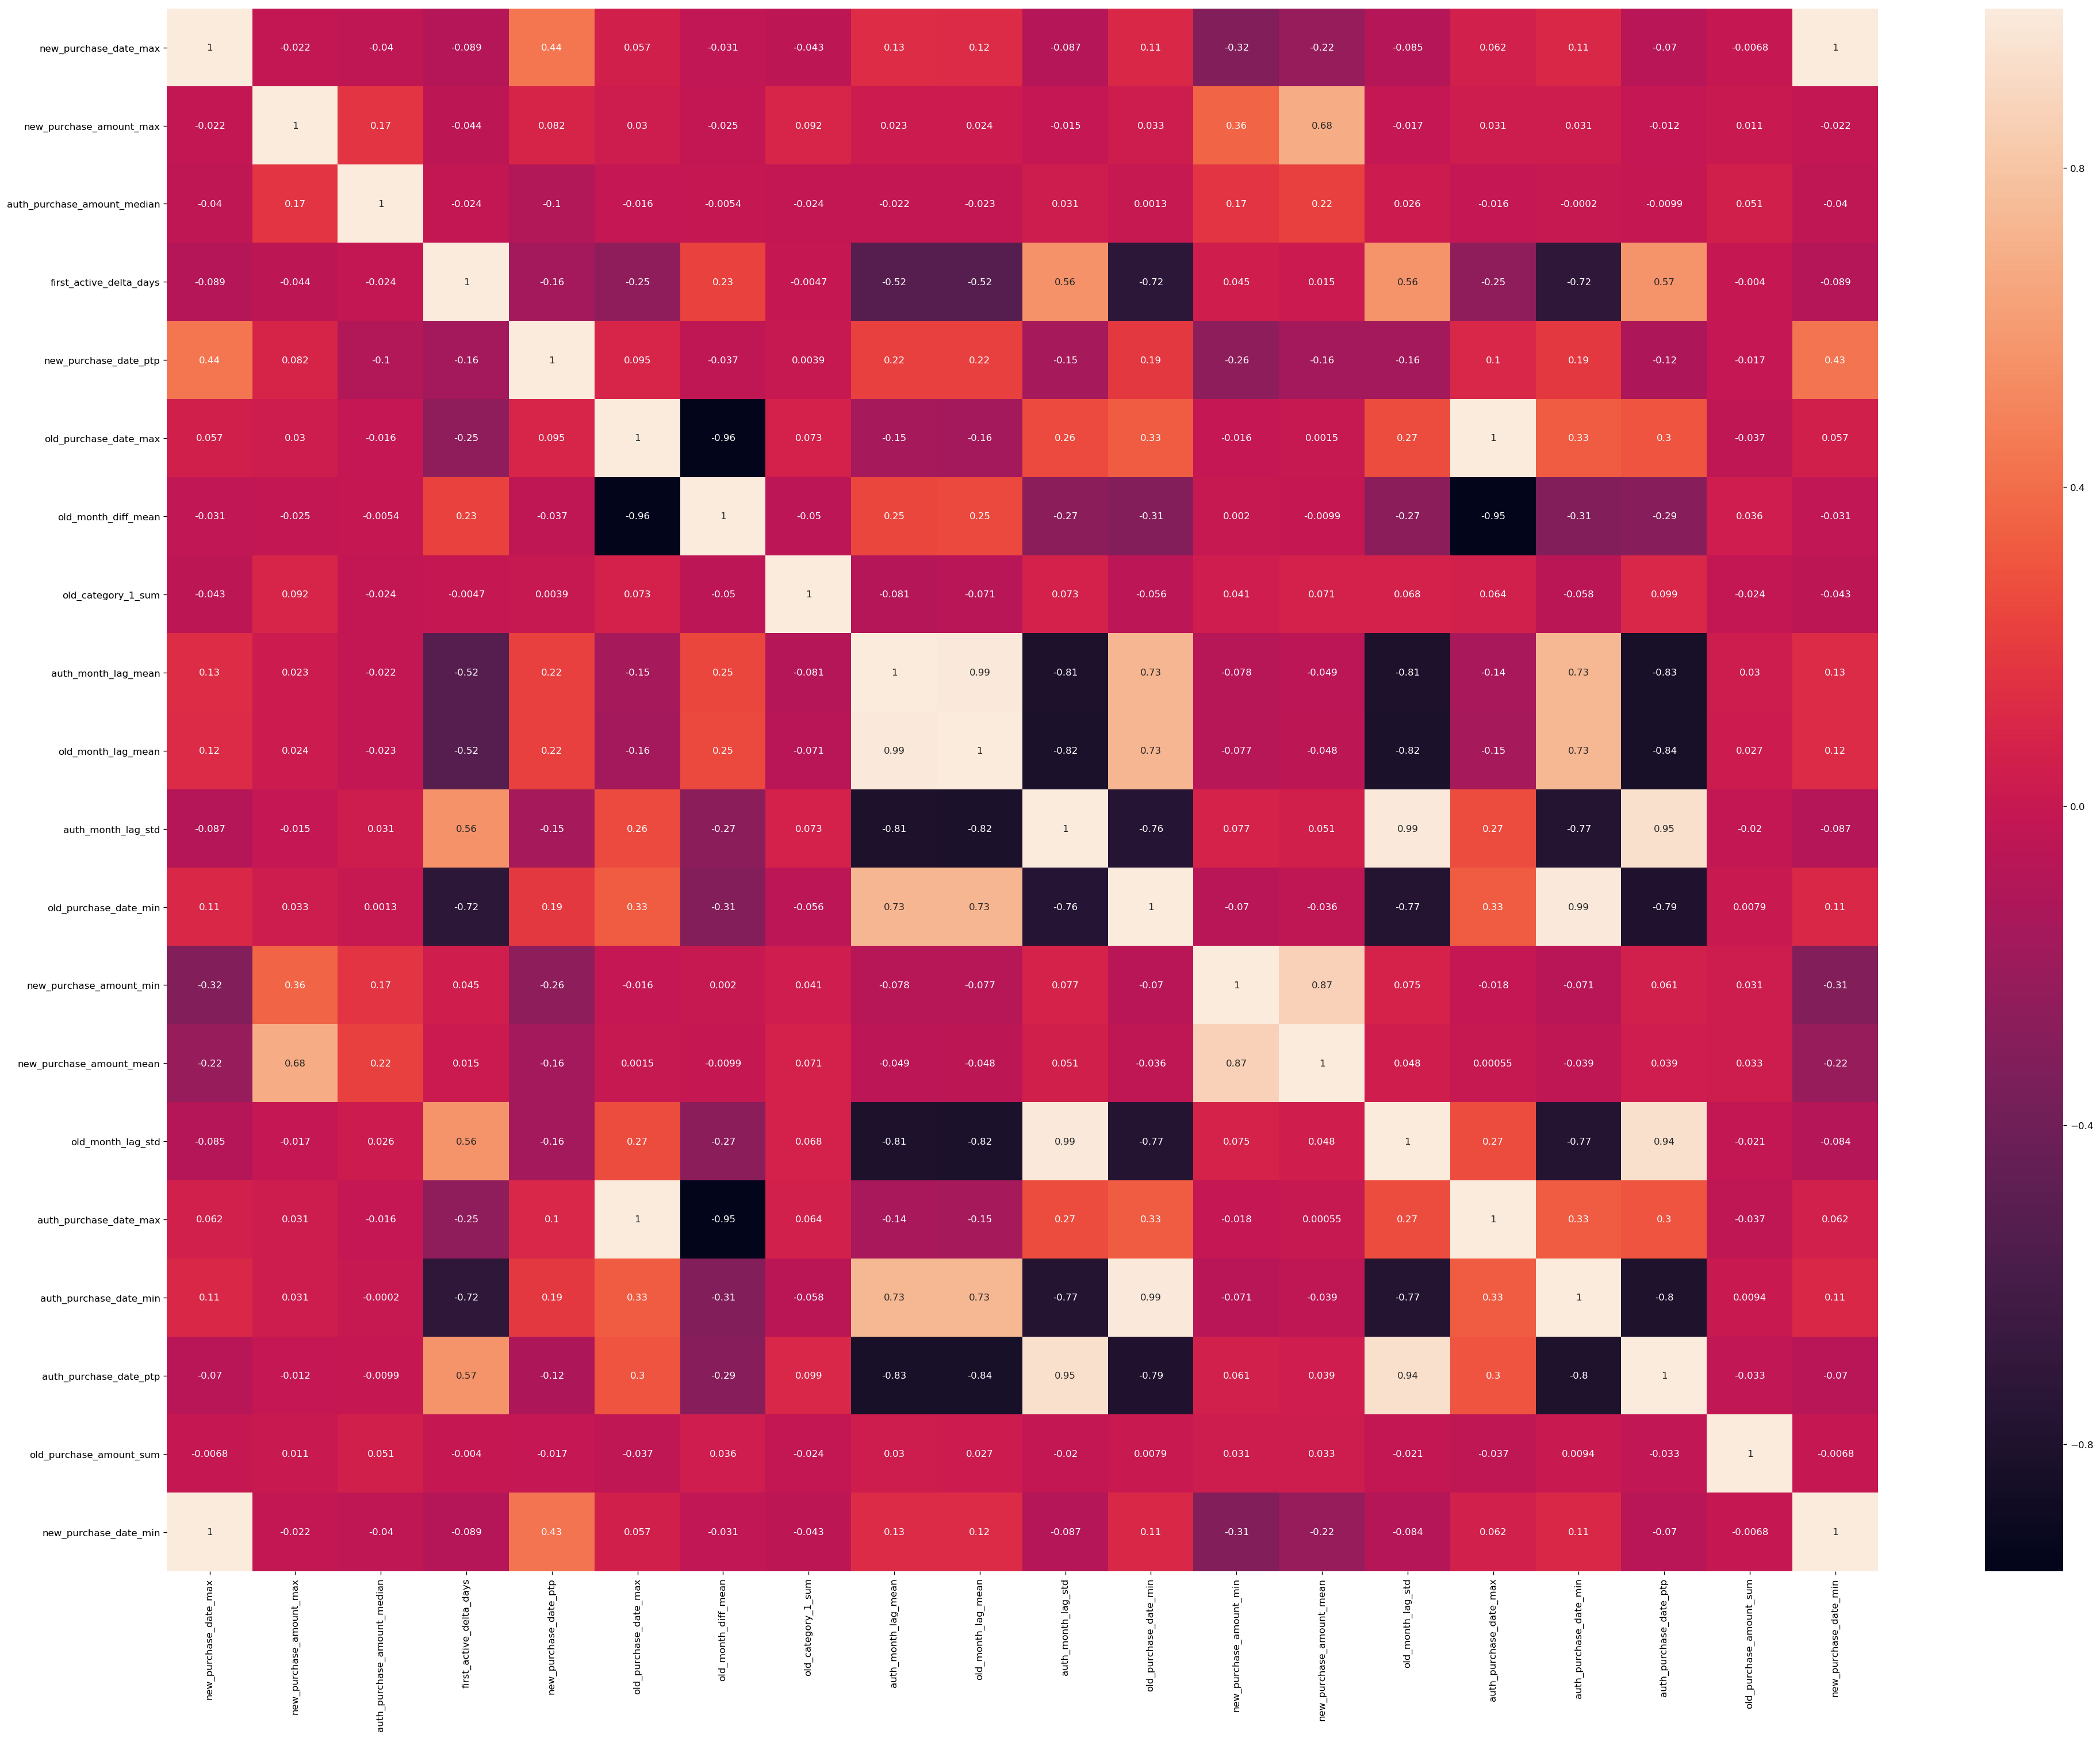

In [7]:
train_sm = train[cols[:20]][:5000]
corr = train_sm.corr()
plt.figure(num=None, figsize=(40,30), dpi=120, facecolor='w', edgecolor='k')
sb.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True
          )

# Note the strong negative correlations to new_purchase_amount_sum. 
# I suspect this is because of the zero filled values when we joined
# train with transactions_new (which don't line up 1:1)

# When we reduce features this will be less ugly again

In [35]:
train_sm = train[cols[1:]][:10]
cov = np.cov(train_sm, ddof=1)
display(pd.DataFrame(cov))

# train_sm.to_csv('input/foo.csv')



,0,1,2,3,4,5,6,7,8,9
0,1.026541e+17,1.021465e+17,1.023236e+17,1.028835e+17,1.029892e+17,1.015318e+17,1.022356e+17,1.026994e+17,1.026191e+17,1.022890e+17
1,1.021465e+17,1.016463e+17,1.018235e+17,1.023719e+17,1.024755e+17,1.010284e+17,1.017358e+17,1.021865e+17,1.021077e+17,1.017890e+17
2,1.023236e+17,1.018235e+17,1.020016e+17,1.025489e+17,1.026523e+17,1.012035e+17,1.019135e+17,1.023630e+17,1.022845e+17,1.019669e+17
3,1.028835e+17,1.023719e+17,1.025489e+17,1.031152e+17,1.032220e+17,1.017594e+17,1.024607e+17,1.029320e+17,1.028508e+17,1.025141e+17
4,1.029892e+17,1.024755e+17,1.026523e+17,1.032220e+17,1.033295e+17,1.018644e+17,1.025641e+17,1.030392e+17,1.029576e+17,1.026175e+17
5,1.015318e+17,1.010284e+17,1.012035e+17,1.017594e+17,1.018644e+17,1.004221e+17,1.011164e+17,1.015780e+17,1.014982e+17,1.011692e+17
6,1.022356e+17,1.017358e+17,1.019135e+17,1.024607e+17,1.025641e+17,1.011164e+17,1.018256e+17,1.022749e+17,1.021963e+17,1.018789e+17
7,1.026994e+17,1.021865e+17,1.023630e+17,1.029320e+17,1.030392e+17,1.015780e+17,1.022749e+17,1.027502e+17,1.026687e+17,1.023282e+17
8,1.026191e+17,1.021077e+17,1.022845e+17,1.028508e+17,1.029576e+17,1.014982e+17,1.021963e+17,1.026687e+17,1.025877e+17,1.022497e+17
9,1.022890e+17,1.017890e+17,1.019669e+17,1.025141e+17,1.026175e+17,1.011692e+17,1.018789e+17,1.023282e+17,1.022497e+17,1.019322e+17


## Train and test model using ALL engineered features 

In [9]:
print(len(train.columns))
for col in train.columns:
    print("'{}',".format(col))

108
'feature_3',
'first_active_delta_days',
'feature_1_1',
'feature_1_2',
'feature_1_3',
'feature_1_4',
'feature_1_5',
'feature_2_1',
'feature_2_2',
'feature_2_3',
'old_purchase_amount_sum',
'old_purchase_amount_mean',
'old_purchase_amount_min',
'old_purchase_amount_max',
'old_purchase_amount_std',
'old_subsector_id_nunique',
'old_merchant_category_id_nunique',
'old_merchant_id_nunique',
'old_installments_sum',
'old_installments_mean',
'old_city_id_nunique',
'old_state_id_nunique',
'old_category_1_sum',
'old_category_2_1.0_sum',
'old_category_2_2.0_sum',
'old_category_2_3.0_sum',
'old_category_2_4.0_sum',
'old_category_2_5.0_sum',
'old_category_3_A_sum',
'old_category_3_B_sum',
'old_category_3_C_sum',
'old_month_lag_mean',
'old_month_lag_min',
'old_month_lag_max',
'old_month_lag_std',
'old_authorized_flag_sum',
'old_month_diff_mean',
'old_month_diff_min',
'old_month_diff_max',
'old_month_diff_std',
'old_purchase_date_ptp',
'old_purchase_date_min',
'old_purchase_date_max',
'new_purchase

In [21]:
print(cols[:10])

Index(['new_purchase_date_max', 'new_purchase_amount_max',
       'auth_purchase_amount_median', 'first_active_delta_days',
       'new_purchase_date_ptp', 'old_purchase_date_max', 'old_month_diff_mean',
       'old_category_1_sum', 'auth_month_lag_mean', 'old_month_lag_mean'],
      dtype='object', name='feature')


## Test area to play with different sets of features

In [34]:
def feature_play():
    np.random.seed(11)
    #This is just to play around with different engineered features. 

    
    train_selected_features = train[cols[:50]]
    
    
    data_len = len(train)
    mask = np.random.rand(data_len) < 0.8

    train_data = train_selected_features.values[mask]
    train_labels = target.values.flatten()[mask]
    test_data = train_selected_features.values[~mask]
    test_labels = target.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("Using the following features, the Mean Squared Error is: {:0.3f}".format(mse))
    print(train_selected_features.columns)
    
    return mse

# if play_mse:
#     print("Previous MSE: {:0.3f}".format(play_mse))
    
play_mse = feature_play()

Using the following features, the Mean Squared Error is: 13.975
Index(['new_purchase_date_max', 'new_purchase_amount_max',
       'auth_purchase_amount_median', 'first_active_delta_days',
       'new_purchase_date_ptp', 'old_purchase_date_max', 'old_month_diff_mean',
       'old_category_1_sum', 'auth_month_lag_mean', 'old_month_lag_mean',
       'auth_month_lag_std', 'old_purchase_date_min',
       'new_purchase_amount_min', 'new_purchase_amount_mean',
       'old_month_lag_std', 'auth_purchase_date_max', 'auth_purchase_date_min',
       'auth_purchase_date_ptp', 'old_purchase_amount_sum',
       'new_purchase_date_min', 'new_month_lag_mean',
       'old_purchase_amount_min', 'auth_purchase_amount_max',
       'auth_category_1_sum', 'auth_purchase_amount_mean',
       'old_installments_sum', 'old_category_2_1.0_sum',
       'old_purchase_amount_max', 'auth_purchase_amount_min',
       'old_installments_mean', 'old_month_diff_std', 'old_purchase_date_ptp',
       'new_purchase_amount_s